In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import time
import os
from os.path import join
import pickle as pkl
import json
import torch
import torch as th
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
import einops
import matplotlib.pyplot as plt
from collections import defaultdict
from easydict import EasyDict as edict
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
import circuit_toolkit
# print(circuit_toolkit.__file__)
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

In [5]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/SiT")
# sys.path.append("/n/home12/binxuwang/Github/DiT")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
# from train_edm import create_model, edm_sampler, EDM
# from edm_utils import edm_sampler_inpaint, create_edm, get_default_config
# from rule_utils import get_rule_img, get_obj_list, get_rule_list, check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from rule_new_utils import check_r3_r2_batch, infer_rule_from_sample_batch, compute_rule_statistics
from models import SiT_models, SiT
from transport import create_transport, Sampler

### Load in SiT model

In [8]:
SiT_configs = {
    "SiT_XL_1": {"depth": 28, "hidden_size": 1152, "patch_size": 1, "num_heads": 16},
    "SiT_XL_3": {"depth": 28, "hidden_size": 1152, "patch_size": 3, "num_heads": 16},
    "SiT_L_1": {"depth": 24, "hidden_size": 1024, "patch_size": 1, "num_heads": 16},
    "SiT_L_3": {"depth": 24, "hidden_size": 1024, "patch_size": 3, "num_heads": 16},
    "SiT_B_1": {"depth": 12, "hidden_size": 768, "patch_size": 1, "num_heads": 12},
    "SiT_B_3": {"depth": 12, "hidden_size": 768, "patch_size": 3, "num_heads": 12},
    "SiT_S_1": {"depth": 12, "hidden_size": 384, "patch_size": 1, "num_heads": 6},
    "SiT_S_3": {"depth": 12, "hidden_size": 384, "patch_size": 3, "num_heads": 6},
}

In [9]:
device = "cuda"

In [15]:
class_dropout_prob = 1.0
num_classes = 0
model_cfg = SiT_configs["SiT_S_1"]
model_SiT = SiT(
        input_size=9,
        in_channels=3,
        num_classes=num_classes,
        class_dropout_prob=class_dropout_prob,
        learn_sigma=True,
        **model_cfg,
    )

In [16]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results

004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None
006-SiT_S_1-stream0_016M_all-Linear-velocity-None
007-SiT_S_1-stream0_16M_all-Linear-velocity-None
008-SiT_S_1-stream1_6M_all-Linear-velocity-None
009-SiT_S_1-stream16M_all-Linear-velocity-None
010-SiT_S_1-stream16M_all-Linear-velocity-None
011-SiT_B_1-stream0_16M_all-Linear-velocity-None
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None
012-SiT_B_1-stream0_016M_all-Linear-velocity-None
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None
013-SiT_B_1-stream16M_all-Linear-velocity-None
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None
014-SiT_B_1-stream1_6M_all-Linear-velocity-None
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None
016-SiT_B_1-stream16M_heldout0-Linear-velocity-None
017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None
018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None
019-SiT_B_1-stream16M_all-Linear-ve

In [29]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
expname = r"014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
ckpt_path = join(ckptdir, "1000000.pt")
state_dict = th.load(ckpt_path, )
model_SiT.load_state_dict(state_dict['ema']) # "model"
model_SiT.to(device).eval();
config = edict(json.load(open(join(expdir, "args.json"), "r")))

In [26]:
# abstract RAVEN dataset
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to("cuda")
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to("cuda")

In [27]:
transport = create_transport(
    config.path_type, #"Linear",
    config.prediction, #"velocity", 
    config.loss_weight, #None, 
    config.train_eps, #None,
    config.sample_eps, #None,
)  # default: velocity; 
transport_sampler = Sampler(transport)

### Test run and rule inference

In [ ]:
batch_size = 2048
zs = th.randn(batch_size, 3, 9, 9).to(device)
ys = torch.zeros((batch_size,), device=device, dtype=torch.int)    
sample_model_kwargs = dict(y=ys)
model_fn = model_SiT.forward
sample_fn = transport_sampler.sample_ode() # default to ode sampling
with th.no_grad():
    samples = sample_fn(zs, model_fn, **sample_model_kwargs)[-1] # takes 75 sec, pretty slow...
samples = ((samples.detach() * dataset_Xstd) + dataset_Xmean).cpu()
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples)
C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)

C3: 1447/2048 (0.71), C3 + C2: 1720/2048 (0.84), AnyValid: 5196/6144 (0.85)


### Load training dataset

In [48]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]


In [49]:
# train_data_fn = "train_inputs_new.pt"
# train_attrs = torch.load(f'/n/home12/binxuwang/Github/DiffusionReasoning/{train_data_fn}')
# train_attrs = train_attrs.to(int)
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)

In [50]:
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

In [51]:
print(train_sample_img[0,0])

tensor([[[ 5,  5,  5,  5,  5, -1,  5, -1,  5],
         [ 5,  5,  5, -1, -1,  5,  5,  5,  5],
         [ 5,  5,  5,  5, -1, -1, -1,  5,  5],
         [-1,  6,  6,  6, -1, -1,  6,  6,  6],
         [-1, -1, -1, -1,  6,  6,  6,  6,  6],
         [-1,  6,  6,  6,  6, -1, -1,  6,  6],
         [ 2, -1,  2,  2,  2,  2, -1, -1,  2],
         [ 2,  2, -1,  2, -1, -1, -1, -1, -1],
         [ 2,  2,  2, -1,  2,  2,  2,  2, -1]],

        [[ 4,  4,  4,  2,  2, -1,  9, -1,  9],
         [ 4,  4,  4, -1, -1,  2,  9,  9,  9],
         [ 4,  4,  4,  2, -1, -1, -1,  9,  9],
         [-1,  5,  1,  5, -1, -1,  7,  1,  5],
         [-1, -1, -1, -1,  0,  1,  7,  4,  0],
         [-1,  3,  1,  8,  2, -1, -1,  7,  6],
         [ 5, -1,  5,  3,  3,  3, -1, -1,  6],
         [ 5,  5, -1,  3, -1, -1, -1, -1, -1],
         [ 5,  5,  5, -1,  3,  3,  6,  6, -1]],

        [[ 4,  8,  4,  5,  0, -1,  6, -1,  4],
         [ 0,  5,  4, -1, -1,  1,  2,  5,  8],
         [ 7,  3,  1,  2, -1, -1, -1,  8,  2],
         

In [52]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


### Utils to train a linear probe

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# Define the linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x


# Define the training loop
def train_model(model, train_loader, num_epochs, learning_rate, print_every=50,
                eval_every=500, eval_func=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_record = []
    test_record = []
    for epoch in range(num_epochs):
        acc_total = 0
        cnt_total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            acc_cnt = (outputs.argmax(dim=1) == labels).sum().item()
            acc_total += acc_cnt
            cnt_total += len(labels)
        accuracy = acc_total / cnt_total
        if (epoch + 1) % print_every == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
        train_record.append((epoch, loss.item(), accuracy))
        if ((epoch + 1) % eval_every == 0 or epoch == num_epochs - 1) and eval_func is not None:
            test_acc, _ = eval_func(model)
            test_record.append((epoch, test_acc))
    train_record = pd.DataFrame(train_record, columns=["epoch", "loss", "accuracy"])
    test_record = pd.DataFrame(test_record, columns=["epoch", "accuracy"])
    return train_record, test_record


def test_model(model, test_loader):
    acc_total = 0
    cnt_total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        with th.no_grad():
            outputs = model(inputs)
        pred_cls = outputs.argmax(dim=1)
        acc_cnt = (pred_cls == labels).sum().item()
        acc_total += acc_cnt
        cnt_total += len(labels)
    accuracy = acc_total / cnt_total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, pred_cls


def fit_SGD_linear_classifier(train_X, train_y, test_X=None, test_y=None, 
                              num_classes=40, 
                              batch_size=1024, num_epochs=100, 
                              learning_rate = 0.001, print_every=100, eval_every=500,):
    # Define the linear classifier model
    input_size = train_X.shape[1]
    model = LinearClassifier(input_size, num_classes).to("cuda")
    if batch_size is None:
        feat_loader = [(train_X.to("cuda"), train_y.to("cuda"))]
    else:
        feat_dataset = TensorDataset(train_X.to("cuda"), train_y.to("cuda")) # .to("cuda")
        feat_loader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True,
                             drop_last=True) # pin_memory=True, num_workers=
    
    if test_X is not None and test_y is not None:
        if batch_size is None:
            test_feat_loader = [(test_X.to("cuda"), test_y.to("cuda"))]
        else:
            test_dataset = TensorDataset(test_X.to("cuda"), test_y.to("cuda")) # .to("cuda")
            test_feat_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Define the training loop
    train_record, test_record = train_model(model, feat_loader, num_epochs, learning_rate, print_every=print_every, eval_every=eval_every,
                eval_func=lambda model: test_model(model, test_feat_loader) if test_feat_loader is not None else None)
    # Define the testing loop
    test_acc, pred_cls = test_model(model, test_feat_loader)
    results = edict()
    results.train_record = train_record
    results.test_record = test_record
    results.test_acc = test_acc
    results.pred_cls = pred_cls
    return model, results


In [54]:
def train_pca_sgd_classifiers(
    feature_col,
    feature_col_test,
    y_train,
    y_test,
    PC_dim=1024,
    noPCA=False,
    num_classes=40,
    batch_size=None,
    num_epochs=5000,
    print_every=250,
    eval_every=1000,
    learning_rate=0.005,
    device='cuda'  # Specify 'cuda' or 'cpu'
):
    """
    Trains SGD linear classifiers on PCA-transformed features for each layer.

    Args:
        feature_col (dict): Training features for each layer.
        feature_col_test (dict): Test features for each layer.
        y_train (torch.Tensor or np.ndarray): Training labels.
        y_test (torch.Tensor or np.ndarray): Test labels.
        PC_dim (int, optional): Number of principal components. Defaults to 1024.
        noPCA (bool, optional): Whether to skip PCA. Defaults to False.
        num_classes (int, optional): Number of target classes. Defaults to 40.
        batch_size (int, optional): Batch size for SGD. Defaults to None.
        num_epochs (int, optional): Number of training epochs. Defaults to 5000.
        print_every (int, optional): Frequency of printing progress. Defaults to 250.
        eval_every (int, optional): Frequency of evaluating on test set. Defaults to 1000.
        learning_rate (float, optional): Learning rate for SGD. Defaults to 0.005.
        device (str, optional): Device to use ('cuda' or 'cpu'). Defaults to 'cuda'.

    Returns:
        model_PCA_col (dict): Trained models for each layer.
        PC_proj_col (dict): PCA projection parameters for each layer.
        results_col (dict): Training and evaluation results for each layer.
    """
    model_PCA_col = {}
    PC_proj_col = {}
    results_col = {}

    for layerkey in feature_col.keys():
        print(f"Processing layer: {layerkey}")
        t0 = time.time()

        # Reshape feature matrices
        featmat = feature_col[layerkey].view(len(feature_col[layerkey]), -1)
        featmat_test = feature_col_test[layerkey].view(len(feature_col_test[layerkey]), -1)

        # Compute mean of training features
        featmean = featmat.mean(dim=0)
        t1 = time.time()

        if noPCA:
            # Center and normalize features without PCA
            feat_PCA = (featmat - featmean[None, :]).to(device)
            feat_PCA_std = feat_PCA.std(dim=0)
            feat_PCA = feat_PCA / feat_PCA_std[None, :]
            feat_PCA_test = (featmat_test - featmean[None, :]).to(device)
            feat_PCA_test = feat_PCA_test / feat_PCA_std[None, :]
        else:
            # Perform PCA
            centered_feat = (featmat - featmean[None, :]).to(device)
            U, S, V = torch.pca_lowrank(centered_feat, q=PC_dim, center=False, niter=3)
            print(f"PCA components for layer {layerkey}: U shape {U.shape}, S shape {S.shape}, V shape {V.shape}")
            # Clean up unnecessary variables
            del U, S
            torch.cuda.empty_cache()

            # Project training and test features
            feat_PCA = centered_feat @ V
            feat_PCA_std = feat_PCA.std(dim=0)
            feat_PCA = feat_PCA / feat_PCA_std[None, :]
            feat_PCA_test = (featmat_test - featmean[None, :]).to(device) @ V
            feat_PCA_test = feat_PCA_test / feat_PCA_std[None, :]
            torch.cuda.empty_cache()
            V = V.cpu()

        t2 = time.time()

        # Train the SGD linear classifier
        model, results_dict = fit_SGD_linear_classifier(
            feat_PCA, y_train, feat_PCA_test, y_test,
            num_classes=num_classes,
            batch_size=batch_size,
            num_epochs=num_epochs,
            print_every=print_every,
            eval_every=eval_every,
            learning_rate=learning_rate
        )

        t3 = time.time()

        print(f"Layer {layerkey} - PCA time: {t1 - t0:.2f}s, "
              f"PCA transform time: {t2 - t1:.2f}s, "
              f"Training time: {t3 - t2:.2f}s")

        # Store the trained model and PCA projection parameters
        model_PCA_col[layerkey] = model
        PC_proj_col[layerkey] = {
            'V': V.cpu() if not noPCA else None,  # PCA components
            'mean': featmean.cpu(),
            'std': feat_PCA_std.cpu()
        }
        results_col[layerkey] = results_dict
        del feat_PCA, feat_PCA_test

    return model_PCA_col, PC_proj_col, results_col

## Which part of the model has rule representation?
See if any other part of the model has the rule representation

In [55]:
model_SiT

SiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(1, 1), stride=(1, 1))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=384, bias=True)
      (1): SiLU()
      (2): Linear(in_features=384, out_features=384, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1, 384)
  )
  (blocks): ModuleList(
    (0-11): 12 x SiTBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_featur

In [57]:
get_module_name_shapes(model_SiT,inputs_list=[torch.randn(2, 3, 9, 9).to("cuda"), torch.rand(2,).to("cuda"), ], 
                       model_kwargs={"y":torch.zeros(2, dtype=torch.int, device="cuda")});

------------------------------------------------------------------------------------------------------------------------------------------------------
      Layer Id                                           inshape                    outshape                            Type   Module Path                      
        0                                             (2, 3, 9, 9)                (2, 3, 9, 9)                         [Input]   Image                            
        1                                           [(2, 3, 9, 9)]              (2, 384, 9, 9)                        [Conv2d]   .x_embedder.proj                 
        2                                           [(2, 81, 384)]                (2, 81, 384)                      [Identity]   .x_embedder.norm                 
        3                                           [(2, 3, 9, 9)]                (2, 81, 384)                    [PatchEmbed]   .x_embedder                      
        4                           

### Block output

In [59]:
def extract_features_DiT(
    model,
    fetcher,
    data_loader,
    dataset_Xmean,
    dataset_Xstd,
    t_scalar,
    device='cuda',
    progress_bar=True
):
    """
    Extracts features from specified layers of the model for the given dataset.

    Args:
        model (torch.nn.Module): The neural network model.
        fetcher (FeatureFetcher): An instance of the featureFetcher_module.
        data_loader (DataLoader): DataLoader for the dataset.
        dataset_mean (torch.Tensor): Mean for input normalization.
        dataset_std (torch.Tensor): Standard deviation for input normalization.
        t_scalar (float): Scalar value to create the time vector.
        device (str, optional): Device to perform computations on. Defaults to 'cuda'.
        progress_bar (bool, optional): Whether to display a progress bar. Defaults to True.

    Returns:
        dict: A dictionary with layer keys and concatenated activation tensors.
    """
    feature_col = defaultdict(list)
    loader = tqdm(data_loader) if progress_bar else data_loader
    for X_batch, _ in loader:
        # Prepare model inputs
        model_kwargs = {'y': th.zeros(X_batch.size(0), dtype=th.int, device=device)}
        t_vec = th.ones(X_batch.size(0), dtype=th.float, device=device) * t_scalar
        # Normalize the batch
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        # Forward pass with no gradient computation
        with th.no_grad():
            model.forward(X_batch_norm, t_vec, **model_kwargs)
        # Collect activations
        for key, activations in fetcher.activations.items():
            feature_col[key].append(activations.cpu())

    # Concatenate all activations for each layer
    for key in feature_col:
        feature_col[key] = th.cat(feature_col[key], dim=0)
        print(f"{key}: {feature_col[key].shape}")
    return feature_col

In [58]:
fetcher = featureFetcher_module()
# fetcher.record_module(model.blocks[11], target_name="blocks.11")
for i in (2,5,8,11):#range(len(model.blocks)):
    fetcher.record_module(model_SiT.blocks[i], target_name=f"blocks{i}")
# fetcher.cleanup()
feature_col = defaultdict(list)
with th.no_grad():
    model_SiT(torch.randn(2, 3, 9, 9).to("cuda"), torch.rand(2,).to("cuda"), y=torch.zeros(2, dtype=torch.int, device="cuda"))
for key, activations in fetcher.activations.items():
    feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)
fetcher.cleanup()

blocks2 torch.Size([2, 81, 384])
blocks5 torch.Size([2, 81, 384])
blocks8 torch.Size([2, 81, 384])
blocks11 torch.Size([2, 81, 384])
FeatureFetcher hooks all freed


### Check the t encoding 

SiT transport interval is 0, 1 uniform sampling

In [61]:
# t0, t1 = self.check_interval(self.train_eps, self.sample_eps)
# t = th.rand((x1.shape[0],)) * (t1 - t0) + t0
transport.check_interval(None, None)

(0, 1)

#### Block output early 0.1 doesn't quite work

In [62]:
t_scalar = 0.1
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model_SiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_SiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_SiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

FeatureFetcher hooks all freed


  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:36<00:00,  1.60it/s]


blocks5: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


blocks5: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [63]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=1024, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 1024]), S shape torch.Size([1024]), V shape torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8450, Accuracy: 0.0251
Epoch [250/5000], Loss: 0.8199, Accuracy: 0.7480
Epoch [500/5000], Loss: 0.7229, Accuracy: 0.7715
Epoch [750/5000], Loss: 0.6819, Accuracy: 0.7825
Epoch [1000/5000], Loss: 0.6582, Accuracy: 0.7886
Test Accuracy: 0.6708
Epoch [1250/5000], Loss: 0.6424, Accuracy: 0.7934
Epoch [1500/5000], Loss: 0.6310, Accuracy: 0.7961
Epoch [1750/5000], Loss: 0.6224, Accuracy: 0.7986
Epoch [2000/5000], Loss: 0.6157, Accuracy: 0.8004
Test Accuracy: 0.6793
Epoch [2250/5000], Loss: 0.6104, Accuracy: 0.8021
Epoch [2500/5000], Loss: 0.6060, Accuracy: 0.8027
Epoch [2750/5000], Loss: 0.6024, Accuracy: 0.8034
Epoch [3000/5000], Loss: 0.5994, Accuracy: 0.8041
Test Accuracy: 0.6804
Epoch [3250/5000], Loss: 0.5969, Accuracy: 0.8047
Epoch [3500/5000], Loss: 0.5947, Accuracy: 0.8051
Epoch [3750/5000], Loss: 0.5928,

### Very early t 0.02 ~ this doesn't work

In [64]:
t_scalar = 0.02
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model_SiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_SiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_SiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

100%|██████████| 59/59 [00:43<00:00,  1.35it/s]


blocks5: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


blocks5: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [65]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=1024, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 1024]), S shape torch.Size([1024]), V shape torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8546, Accuracy: 0.0245
Epoch [250/5000], Loss: 1.0529, Accuracy: 0.6748
Epoch [500/5000], Loss: 0.9508, Accuracy: 0.6989
Epoch [750/5000], Loss: 0.9090, Accuracy: 0.7093
Epoch [1000/5000], Loss: 0.8856, Accuracy: 0.7156
Test Accuracy: 0.5992
Epoch [1250/5000], Loss: 0.8707, Accuracy: 0.7191
Epoch [1500/5000], Loss: 0.8604, Accuracy: 0.7221
Epoch [1750/5000], Loss: 0.8529, Accuracy: 0.7239
Epoch [2000/5000], Loss: 0.8472, Accuracy: 0.7248
Test Accuracy: 0.6085
Epoch [2250/5000], Loss: 0.8428, Accuracy: 0.7259
Epoch [2500/5000], Loss: 0.8393, Accuracy: 0.7267
Epoch [2750/5000], Loss: 0.8364, Accuracy: 0.7273
Epoch [3000/5000], Loss: 0.8340, Accuracy: 0.7278
Test Accuracy: 0.6092
Epoch [3250/5000], Loss: 0.8320, Accuracy: 0.7283
Epoch [3500/5000], Loss: 0.8302, Accuracy: 0.7288
Epoch [3750/5000], Loss: 0.8287,

### Very late t ~ 1 (not working... )

In [66]:
t_scalar = 0.99
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model_SiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_SiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_SiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

100%|██████████| 59/59 [00:53<00:00,  1.11it/s]


blocks5: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


blocks5: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [69]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=1024, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 1024]), S shape torch.Size([1024]), V shape torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8462, Accuracy: 0.0263
Epoch [250/5000], Loss: 1.5306, Accuracy: 0.5521
Epoch [500/5000], Loss: 1.3139, Accuracy: 0.5962
Epoch [750/5000], Loss: 1.2215, Accuracy: 0.6172
Epoch [1000/5000], Loss: 1.1687, Accuracy: 0.6294
Test Accuracy: 0.5127
Epoch [1250/5000], Loss: 1.1343, Accuracy: 0.6379
Epoch [1500/5000], Loss: 1.1101, Accuracy: 0.6438
Epoch [1750/5000], Loss: 1.0924, Accuracy: 0.6481
Epoch [2000/5000], Loss: 1.0789, Accuracy: 0.6512
Test Accuracy: 0.5357
Epoch [2250/5000], Loss: 1.0684, Accuracy: 0.6537
Epoch [2500/5000], Loss: 1.0601, Accuracy: 0.6558
Epoch [2750/5000], Loss: 1.0534, Accuracy: 0.6578
Epoch [3000/5000], Loss: 1.0478, Accuracy: 0.6597
Test Accuracy: 0.5435
Epoch [3250/5000], Loss: 1.0432, Accuracy: 0.6607
Epoch [3500/5000], Loss: 1.0393, Accuracy: 0.6616
Epoch [3750/5000], Loss: 1.0360,

In [67]:
feature_avg_col = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_last_col = {k: v[:, -1] for k, v in feature_col.items()}
feature_last_col_test = {k: v[:, -1] for k, v in feature_col_test.items()}

In [68]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train, y_test,
    PC_dim=None, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8256, Accuracy: 0.0273
Epoch [250/5000], Loss: 1.7013, Accuracy: 0.5004
Epoch [500/5000], Loss: 1.4548, Accuracy: 0.5607
Epoch [750/5000], Loss: 1.3253, Accuracy: 0.5941
Epoch [1000/5000], Loss: 1.2418, Accuracy: 0.6158
Test Accuracy: 0.6020
Epoch [1250/5000], Loss: 1.1819, Accuracy: 0.6320
Epoch [1500/5000], Loss: 1.1367, Accuracy: 0.6450
Epoch [1750/5000], Loss: 1.1008, Accuracy: 0.6545
Epoch [2000/5000], Loss: 1.0715, Accuracy: 0.6625
Test Accuracy: 0.6465
Epoch [2250/5000], Loss: 1.0467, Accuracy: 0.6694
Epoch [2500/5000], Loss: 1.0258, Accuracy: 0.6755
Epoch [2750/5000], Loss: 1.0076, Accuracy: 0.6805
Epoch [3000/5000], Loss: 0.9916, Accuracy: 0.6849
Test Accuracy: 0.6663
Epoch [3250/5000], Loss: 0.9775, Accuracy: 0.6889
Epoch [3500/5000], Loss: 0.9649, Accuracy: 0.6927
Epoch [3750/5000], Loss: 0.9533, Accuracy: 0.6955
Epoch [4000/5000], Loss: 0.9433, Accuracy: 0.6981
Test Accuracy: 0.6771
Epoch [4250/5000], Loss: 0.9338, Accuracy:

In [70]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train, y_test,
    PC_dim=None, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.05,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8554, Accuracy: 0.0213
Epoch [250/5000], Loss: 1.8759, Accuracy: 0.4603
Epoch [500/5000], Loss: 1.3052, Accuracy: 0.5935
Epoch [750/5000], Loss: 1.2309, Accuracy: 0.6134
Epoch [1000/5000], Loss: 1.1767, Accuracy: 0.6267
Test Accuracy: 0.6142
Epoch [1250/5000], Loss: 1.2961, Accuracy: 0.6064
Epoch [1500/5000], Loss: 1.1012, Accuracy: 0.6506
Epoch [1750/5000], Loss: 1.0763, Accuracy: 0.6576
Epoch [2000/5000], Loss: 1.0623, Accuracy: 0.6596
Test Accuracy: 0.6432
Epoch [2250/5000], Loss: 1.0457, Accuracy: 0.6637
Epoch [2500/5000], Loss: 1.0272, Accuracy: 0.6701
Epoch [2750/5000], Loss: 1.4363, Accuracy: 0.6006
Epoch [3000/5000], Loss: 0.9951, Accuracy: 0.6806
Test Accuracy: 0.6631
Epoch [3250/5000], Loss: 0.9842, Accuracy: 0.6838
Epoch [3500/5000], Loss: 0.9781, Accuracy: 0.6856
Epoch [3750/5000], Loss: 0.9794, Accuracy: 0.6822
Epoch [4000/5000], Loss: 0.9720, Accuracy: 0.6848
Test Accuracy: 0.6677
Epoch [4250/5000], Loss: 1.5547, Accuracy:

### Middel time t ~ 0.5 working a bit better

In [ ]:
t_scalar = 0.5
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model_SiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_SiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_SiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


blocks5: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


blocks5: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [ ]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=1024, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 1024]), S shape torch.Size([1024]), V shape torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8595, Accuracy: 0.0236
Epoch [250/5000], Loss: 0.4368, Accuracy: 0.8811
Epoch [500/5000], Loss: 0.3277, Accuracy: 0.9097
Epoch [750/5000], Loss: 0.2797, Accuracy: 0.9208
Epoch [1000/5000], Loss: 0.2510, Accuracy: 0.9279
Test Accuracy: 0.8232
Epoch [1250/5000], Loss: 0.2312, Accuracy: 0.9327
Epoch [1500/5000], Loss: 0.2165, Accuracy: 0.9364
Epoch [1750/5000], Loss: 0.2049, Accuracy: 0.9393
Epoch [2000/5000], Loss: 0.1955, Accuracy: 0.9416
Test Accuracy: 0.8253
Epoch [2250/5000], Loss: 0.1876, Accuracy: 0.9437
Epoch [2500/5000], Loss: 0.1809, Accuracy: 0.9453
Epoch [2750/5000], Loss: 0.1750, Accuracy: 0.9467
Epoch [3000/5000], Loss: 0.1698, Accuracy: 0.9480
Test Accuracy: 0.8221
Epoch [3250/5000], Loss: 0.1651, Accuracy: 0.9492
Epoch [3500/5000], Loss: 0.1609, Accuracy: 0.9503
Epoch [3750/5000], Loss: 0.1571,

In [ ]:
feature_avg_col = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_last_col = {k: v[:, -1] for k, v in feature_col.items()}
feature_last_col_test = {k: v[:, -1] for k, v in feature_col_test.items()}

In [ ]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train, y_test,
    PC_dim=None, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8451, Accuracy: 0.0229
Epoch [250/5000], Loss: 0.4860, Accuracy: 0.8466
Epoch [500/5000], Loss: 0.3952, Accuracy: 0.8701
Epoch [750/5000], Loss: 0.3535, Accuracy: 0.8817
Epoch [1000/5000], Loss: 0.3279, Accuracy: 0.8895
Test Accuracy: 0.8655
Epoch [1250/5000], Loss: 0.3100, Accuracy: 0.8941
Epoch [1500/5000], Loss: 0.2965, Accuracy: 0.8976
Epoch [1750/5000], Loss: 0.2858, Accuracy: 0.9006
Epoch [2000/5000], Loss: 0.2770, Accuracy: 0.9031
Test Accuracy: 0.8740
Epoch [2250/5000], Loss: 0.2696, Accuracy: 0.9052
Epoch [2500/5000], Loss: 0.2633, Accuracy: 0.9069
Epoch [2750/5000], Loss: 0.2580, Accuracy: 0.9083
Epoch [3000/5000], Loss: 0.2531, Accuracy: 0.9095
Test Accuracy: 0.8763
Epoch [3250/5000], Loss: 0.2489, Accuracy: 0.9107
Epoch [3500/5000], Loss: 0.2451, Accuracy: 0.9117
Epoch [3750/5000], Loss: 0.2417, Accuracy: 0.9129
Epoch [4000/5000], Loss: 0.2387, Accuracy: 0.9136
Test Accuracy: 0.8772
Epoch [4250/5000], Loss: 0.2360, Accuracy:

### Middle to late time t ~ 0.8? (yes this works)

In [75]:
t_scalar = 0.8
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model_SiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_SiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_SiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

100%|██████████| 59/59 [01:05<00:00,  1.11s/it]


blocks5: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


blocks5: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [78]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=1024, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 1024]), S shape torch.Size([1024]), V shape torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8472, Accuracy: 0.0256
Epoch [250/5000], Loss: 0.3276, Accuracy: 0.9192
Epoch [500/5000], Loss: 0.2292, Accuracy: 0.9414
Epoch [750/5000], Loss: 0.1874, Accuracy: 0.9510
Epoch [1000/5000], Loss: 0.1628, Accuracy: 0.9570
Test Accuracy: 0.8574
Epoch [1250/5000], Loss: 0.1460, Accuracy: 0.9609
Epoch [1500/5000], Loss: 0.1336, Accuracy: 0.9640
Epoch [1750/5000], Loss: 0.1239, Accuracy: 0.9663
Epoch [2000/5000], Loss: 0.1160, Accuracy: 0.9681
Test Accuracy: 0.8549
Epoch [2250/5000], Loss: 0.1094, Accuracy: 0.9700
Epoch [2500/5000], Loss: 0.1038, Accuracy: 0.9712
Epoch [2750/5000], Loss: 0.0989, Accuracy: 0.9722
Epoch [3000/5000], Loss: 0.0947, Accuracy: 0.9733
Test Accuracy: 0.8516
Epoch [3250/5000], Loss: 0.0909, Accuracy: 0.9740
Epoch [3500/5000], Loss: 0.0876, Accuracy: 0.9747
Epoch [3750/5000], Loss: 0.0845,

In [76]:
feature_avg_col = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_last_col = {k: v[:, -1] for k, v in feature_col.items()}
feature_last_col_test = {k: v[:, -1] for k, v in feature_col_test.items()}

In [77]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train, y_test,
    PC_dim=None, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8384, Accuracy: 0.0275
Epoch [250/5000], Loss: 0.3325, Accuracy: 0.8945
Epoch [500/5000], Loss: 0.2651, Accuracy: 0.9113
Epoch [750/5000], Loss: 0.2346, Accuracy: 0.9197
Epoch [1000/5000], Loss: 0.2158, Accuracy: 0.9258
Test Accuracy: 0.9073
Epoch [1250/5000], Loss: 0.2027, Accuracy: 0.9291
Epoch [1500/5000], Loss: 0.1928, Accuracy: 0.9319
Epoch [1750/5000], Loss: 0.1849, Accuracy: 0.9344
Epoch [2000/5000], Loss: 0.1785, Accuracy: 0.9364
Test Accuracy: 0.9132
Epoch [2250/5000], Loss: 0.1732, Accuracy: 0.9381
Epoch [2500/5000], Loss: 0.1686, Accuracy: 0.9393
Epoch [2750/5000], Loss: 0.1647, Accuracy: 0.9404
Epoch [3000/5000], Loss: 0.1613, Accuracy: 0.9414
Test Accuracy: 0.9146
Epoch [3250/5000], Loss: 0.1583, Accuracy: 0.9421
Epoch [3500/5000], Loss: 0.1556, Accuracy: 0.9429
Epoch [3750/5000], Loss: 0.1532, Accuracy: 0.9437
Epoch [4000/5000], Loss: 0.1510, Accuracy: 0.9441
Test Accuracy: 0.9149
Epoch [4250/5000], Loss: 0.1489, Accuracy:

### Later t=0.9, this is perfect, accuracy goes to 0.996 perfect!

In [79]:
t_scalar = 0.9
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model_SiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_SiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_SiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

100%|██████████| 59/59 [01:12<00:00,  1.22s/it]


blocks5: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


blocks5: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [80]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=1024, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 1024]), S shape torch.Size([1024]), V shape torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8470, Accuracy: 0.0250
Epoch [250/5000], Loss: 0.5505, Accuracy: 0.8570
Epoch [500/5000], Loss: 0.4052, Accuracy: 0.8907
Epoch [750/5000], Loss: 0.3424, Accuracy: 0.9055
Epoch [1000/5000], Loss: 0.3053, Accuracy: 0.9143
Test Accuracy: 0.8085
Epoch [1250/5000], Loss: 0.2800, Accuracy: 0.9201
Epoch [1500/5000], Loss: 0.2614, Accuracy: 0.9244
Epoch [1750/5000], Loss: 0.2468, Accuracy: 0.9277
Epoch [2000/5000], Loss: 0.2351, Accuracy: 0.9303
Test Accuracy: 0.8139
Epoch [2250/5000], Loss: 0.2253, Accuracy: 0.9322
Epoch [2500/5000], Loss: 0.2170, Accuracy: 0.9343
Epoch [2750/5000], Loss: 0.2098, Accuracy: 0.9361
Epoch [3000/5000], Loss: 0.2035, Accuracy: 0.9377
Test Accuracy: 0.8126
Epoch [3250/5000], Loss: 0.1979, Accuracy: 0.9388
Epoch [3500/5000], Loss: 0.1929, Accuracy: 0.9402
Epoch [3750/5000], Loss: 0.1885,

In [81]:
feature_avg_col = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_last_col = {k: v[:, -1] for k, v in feature_col.items()}
feature_last_col_test = {k: v[:, -1] for k, v in feature_col_test.items()}

In [82]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train, y_test,
    PC_dim=None, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8335, Accuracy: 0.0252
Epoch [250/5000], Loss: 0.4078, Accuracy: 0.8794
Epoch [500/5000], Loss: 0.3108, Accuracy: 0.9030
Epoch [750/5000], Loss: 0.2676, Accuracy: 0.9140
Epoch [1000/5000], Loss: 0.2415, Accuracy: 0.9203
Test Accuracy: 0.9056
Epoch [1250/5000], Loss: 0.2235, Accuracy: 0.9251
Epoch [1500/5000], Loss: 0.2100, Accuracy: 0.9286
Epoch [1750/5000], Loss: 0.1995, Accuracy: 0.9311
Epoch [2000/5000], Loss: 0.1910, Accuracy: 0.9337
Test Accuracy: 0.9148
Epoch [2250/5000], Loss: 0.1838, Accuracy: 0.9360
Epoch [2500/5000], Loss: 0.1778, Accuracy: 0.9380
Epoch [2750/5000], Loss: 0.1727, Accuracy: 0.9393
Epoch [3000/5000], Loss: 0.1679, Accuracy: 0.9409
Test Accuracy: 0.9181
Epoch [3250/5000], Loss: 0.1638, Accuracy: 0.9421
Epoch [3500/5000], Loss: 0.1601, Accuracy: 0.9432
Epoch [3750/5000], Loss: 0.1568, Accuracy: 0.9442
Epoch [4000/5000], Loss: 0.1538, Accuracy: 0.9449
Test Accuracy: 0.9201
Epoch [4250/5000], Loss: 0.1510, Accuracy:

### UMap and repr similarity analysis

In [83]:
from matplotlib.colors import ListedColormap
# Define a discrete colormap
cmap = ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#d000d0'])
row_table = {
    0: "Constant",
    1: "Prog. neg 2",
    2: "Prog. neg 1",
    3: "Prog. pos 1",
    4: "Prog. pos 2",
    5: "Arith. pos",
    6: "Arith. neg",
    7: "XOR",
    8: "OR",
    9: "AND"
}

In [84]:
feature_avg_col_test["blocks11"].shape

torch.Size([40000, 384])

In [85]:
import umap
import matplotlib.pyplot as plt
# Assuming features is your feature matrix and labels is your label array
reducer = umap.UMAP()
embedding = reducer.fit_transform(feature_avg_col_test["blocks11"])

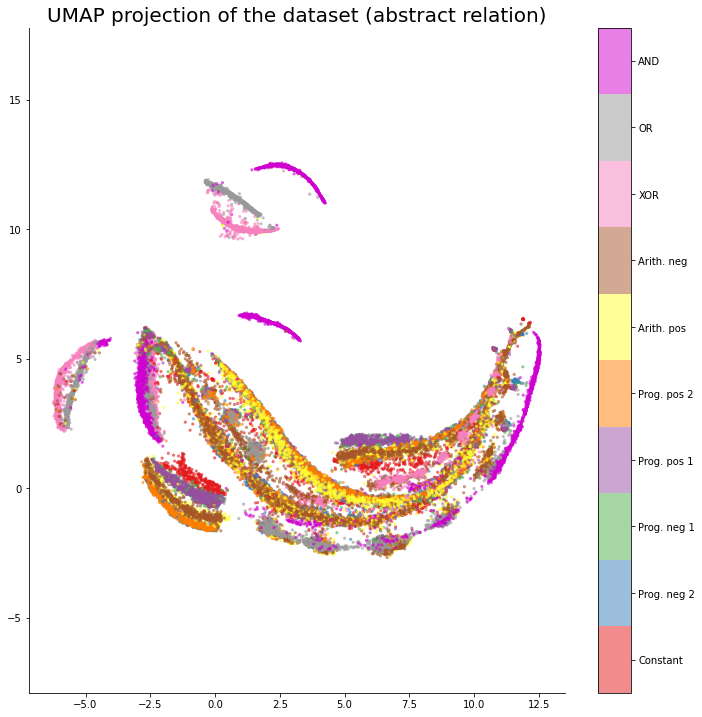

In [86]:
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding[:, 0], embedding[:, 1], c=rela_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation)', fontsize=20);

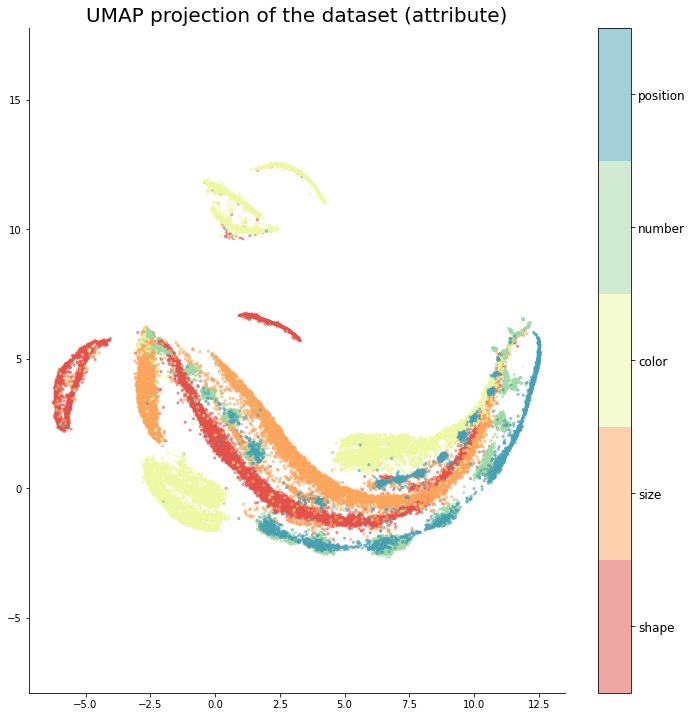

In [87]:
attr_test = (y_test//10) + (y_test > 36).int()
cmap = ListedColormap(sns.color_palette("Spectral", 6))
plt.figure(figsize=(12, 12))
plt.scatter(embedding[:, 0], embedding[:, 1], c=attr_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(6)-0.5)
cb.set_ticks(np.arange(5),)#["shape","size","color","number","position"])
cb.set_ticklabels(["shape","size","color","number","position"], fontsize=12)
plt.title('UMAP projection of the dataset (attribute)', fontsize=20);

### RSA structure

In [88]:
from sklearn.metrics.pairwise import cosine_similarity
layername = "blocks11"#"dec.1x1_in1"#"dec.3x3_up";#"dec.1x1_in1" # "enc.1x1_down"
# Compute the cosine similarity matrix
featmatr = feature_avg_col_test[layername].flatten(start_dim=1)#.squeeze()
feat_shape = feature_avg_col_test[layername].shape[1:]
feat_mean = featmatr.mean(dim=0)
feat_cent = featmatr - feat_mean[None, :]
featmat_sparse = feat_cent[::5,:]
cosine_sim_matrix = cosine_similarity(featmat_sparse)
# print(cosine_sim_matrix)
n = cosine_sim_matrix.shape[0]
reshaped = cosine_sim_matrix.reshape(40, n//40, 40, n//40)
coarse_grained_matrix = reshaped.mean(axis=(1, 3))

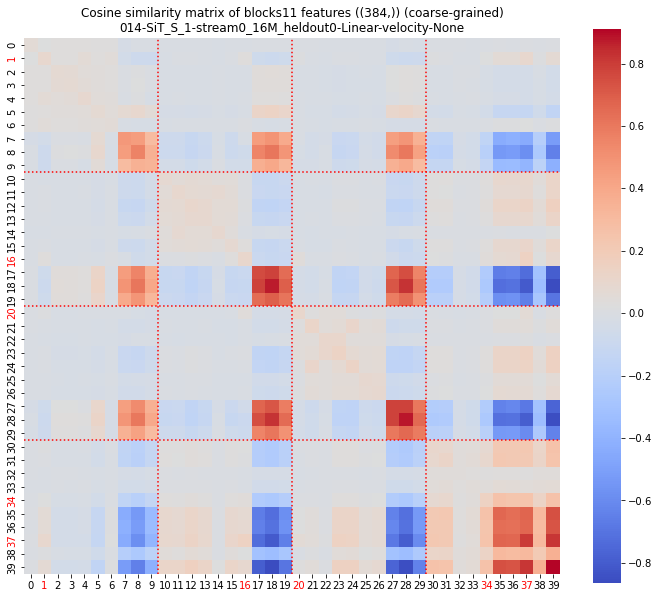

In [89]:
heldout_ids = heldout_rules
plt.figure(figsize=(12,10))
sns.heatmap(coarse_grained_matrix, annot=False, cmap='coolwarm', 
            xticklabels=True, yticklabels=True)
for sep in [10,20,30]:
    plt.axhline(sep, color="r", linestyle=":")
    plt.axvline(sep, color="r", linestyle=":")
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
for i, xtick in enumerate(xticks):
    if i in heldout_ids:  # Change color of every 10th xtick label
        xtick.set_color('red')
for i, ytick in enumerate(yticks):
    if i in heldout_ids:  # Change color of every 10th ytick label
        ytick.set_color('red')
plt.axis("image")
plt.title(f"Cosine similarity matrix of {layername} features ({tuple(feat_shape)}) (coarse-grained)\n{expname}") #  (red=held-out)
# saveallforms(fig_expdir, f"cosine_sim_{layername}_t{t_str}",)
plt.show()